# Importações, carregamento e tratamento dos dados

## Importações e carregamento dos dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [82]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import joblib
import matplotlib.pyplot as plt # Gráficos
import seaborn as sns # Gráficos
from tqdm.notebook import tqdm # Barras de Progresso

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
import tensorflow as tf

from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [84]:
X = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/normal_dataset.csv")

X_drop = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/drop_1.csv")
X_delay = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/delay_1.csv")
X_outOfSequence = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/outOfSequence_1.csv")

## Tratamento dos dados

In [85]:
# Remover as colunas que não vamos usar e criar a coluna de Label nos dados de validação e teste

for X in [X_drop, X_delay, X_outOfSequence]:
  X.drop(columns=[col for col in X.columns if col not in ['Time', 'Length']], inplace=True)
  X['Label'] = 0.0

In [86]:
# Rotulação dos dados em benignos (0.0) e malignos (1.0)

Xs = [X_drop, X_delay, X_outOfSequence]

for j in range(len(Xs)):
  suspicious_indexes = Xs[j][(0.000124 > Xs[j]['Time']) | (Xs[j]['Time'] > 0.000126)].index

  for idx in suspicious_indexes:
    if (idx - 1) > -1:
      if Xs[j].iloc[idx-1, X.columns.get_loc('Length')] == 66 and Xs[j].iloc[idx, X.columns.get_loc('Length')] == 66:
        Xs[j].loc[idx, 'Label'] = 1.0

In [87]:
# Selecionando as colunas que vamos utilizar no treinamento

X = X[['Time', 'Length']]

In [88]:
# Separando os dados dos rótulos

y_drop, X_drop = X_drop['Label'], X_drop.drop(columns=['Label'])
y_delay, X_delay = X_delay['Label'], X_delay.drop(columns=['Label'])
y_outOfSequence, X_outOfSequence = X_outOfSequence['Label'], X_outOfSequence.drop(columns=['Label'])

In [96]:
# Nomalizando os dados

std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)

X_drop = std_scaler.transform(X_drop)
X_delay = std_scaler.transform(X_delay)
X_outOfSequence = std_scaler.transform(X_outOfSequence)

# Definindo Modelos

## KMeans

In [97]:
RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)

In [98]:
# Criamos um subconjunto com 2% dos dados de treinamento

subset_train_size = int(X.shape[0]*0.02)
train_indexes = [i for i in range(subset_train_size)]
X_subset = X[train_indexes,:]

In [99]:
# Analisamos a pontuação obtida na métrica silhouette score para os clusters formados para diferentes valores de K

k_list = list(range(2, 21))
silhouette_score_list = []

for k in tqdm(k_list):
    model_kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=30)
    model_kmeans = model_kmeans.fit(X_subset)

    s_score = silhouette_score(X_subset, model_kmeans.predict(X_subset))
    silhouette_score_list.append(s_score)

  0%|          | 0/19 [00:00<?, ?it/s]

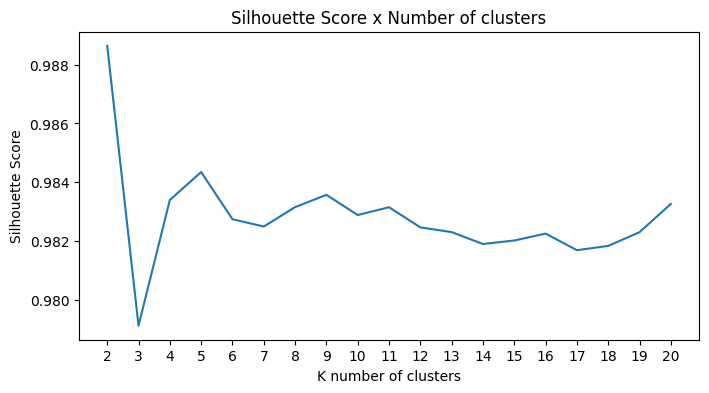

In [100]:
### Não é preciso entender de verdade, é só para plotar o gráfico

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('K number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_xticks(k_list)
ax.set_title('Silhouette Score x Number of clusters')
ax.plot(k_list, silhouette_score_list)

In [101]:
# Definição e treinamento do modelo Kmeans

K_CLUSTERS = 2
model_kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_SEED, n_init=30)
model_kmeans = model_kmeans.fit(X)

### Análise PCA

In [102]:
# Análise PCA

def plot_pca(X, model_kmeans=None, print_centroids = False):
  pca = PCA(n_components=2, random_state=RANDOM_SEED) # Reduziremos a dimensionalidade dos dados para 2
  X_pca = pca.fit_transform(X)


  fig, ax = plt.subplots(figsize=(8, 4))
  ax.set_title('PCA Analysis')

  if print_centroids and model_kmeans is not None:
    cluster_centers_principal_components = pca.transform(model_kmeans.cluster_centers_)
    num_clusters = cluster_centers_principal_components.shape[0]
    X_clusters = model_kmeans.predict(X)

    for cluster in range(num_clusters):
      indexes = np.where(X_clusters == cluster)
      ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')

    for i, cluster_center_pc in enumerate(cluster_centers_principal_components):
      ax.scatter(cluster_center_pc[0], cluster_center_pc[1], c='black', s=8, marker='x')
      ax.annotate(f'Cluster#{i}', (cluster_center_pc[0], cluster_center_pc[1]), size=10)
    ax.legend()

  else:
    ax.scatter(X_pca[:,0], X_pca[:,1], s=1)

<ipython-input-102-96a2e3218ae7>:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')


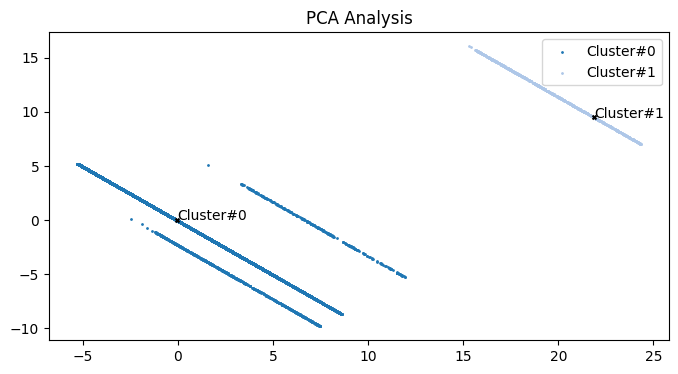

In [103]:
plot_pca(X, model_kmeans, print_centroids=True)

# Avaliando Modelos

## Definindo um threshold e avaliando resultados (funções)

In [104]:
# Função para plotar a curva ROC

def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)

  ## Configurações do gráfico
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [105]:
# Função para calcular a taxa de vedadeiros positivos por ataque

def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})

  total_per_label = aux_df['Label'].value_counts().to_dict()

  correct_predictions_per_label = aux_df.query('Label != 0 and prediction == True').groupby('Label').size().to_dict()

  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 0: # Pula se for benigno
      continue

    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr

  return tpr_per_attack

In [106]:
# Função para calcular métricas gerais

def get_overall_metrics(y_true, y_pred):
  ## tn (verdadeiros negativos), fp (falsos positivos), fn (falsos negativos), tp (verdadeiros positivos)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  acc = (tp+tn)/(tp+tn+fp+fn) ## Cálculo da acurácia (proporção de amostras classificadas corretamente)

  tpr = tp/(tp+fn) ## Cálculo da taxa de verdadeiros positivos
  fpr = fp/(fp+tn) ## Cálculo da taxa de falsos positivos

  precision = tp/(tp+fp) ## Cálculo da precisão (proporção dos verdadeiros positivos dentre todos os positivos obtidos)
  f1 = (2*tpr*precision)/(tpr+precision) ## Cálculo do f1-score (média harmonica entre a precisão e o recall)

  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [107]:
# Função para plotar a matrix de confusão

def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

## Kmeans

In [120]:
X_kmeans, y_kmeans = X_outOfSequence, y_outOfSequence

In [122]:
val_centroids_distances_kmeans = model_kmeans.transform(X_kmeans)
val_anomaly_scores_kmeans = np.min(val_centroids_distances_kmeans, axis=1)

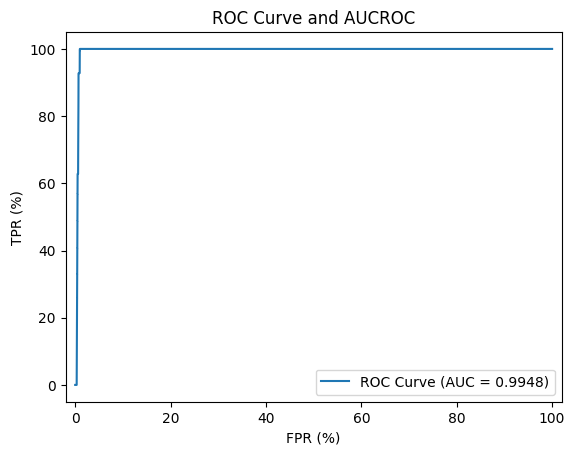

In [123]:
plot_roc_curve(y_kmeans, val_anomaly_scores_kmeans)

In [124]:
# Calculamos a taxa de falsos positivos, taxa de verdadeiros positivos, o threshold e o índice de Youden

fpr_kmeans, tpr_kmeans, thresholds_kmeans = roc_curve(y_kmeans, val_anomaly_scores_kmeans)
df_val_roc_kmeans = pd.DataFrame({'fpr':fpr_kmeans, 'tpr':tpr_kmeans, 'thresholds':thresholds_kmeans})

df_val_roc_kmeans['youden-index'] = df_val_roc_kmeans['tpr'] - df_val_roc_kmeans['fpr']
df_val_roc_kmeans.sort_values('youden-index', ascending=False).drop_duplicates('fpr')[:3] # Limiar ótimo é o 1°

,fpr,tpr,thresholds,youden-index
8780,0.009777,1.0,0.059399,0.990223
8781,0.009781,1.0,0.056816,0.990219
8782,0.009793,1.0,0.056313,0.990207


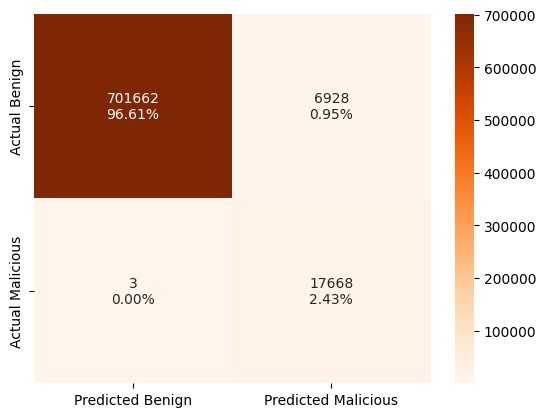

In [126]:
BEST_VALIDATION_THRESHOLD_kmeans = 0.059399
plot_confusion_matrix(y_kmeans, val_anomaly_scores_kmeans > BEST_VALIDATION_THRESHOLD_kmeans)

In [127]:
get_overall_metrics(y_kmeans, val_anomaly_scores_kmeans > BEST_VALIDATION_THRESHOLD_kmeans)

{'acc': 0.9904565989361951,
 'tpr': 0.9998302303208647,
 'fpr': 0.009777163098547821,
 'precision': 0.7183281834444625,
 'f1-score': 0.8360186433860931}